In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import sys
sys.path.append('..') #get root directory



Let's load our data and look at some of the data we have

In [2]:
housing_data = pd.read_csv("../data/external/housing.csv")
housing_data.head()


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


For the housing data, it is all contained within Washington State, USA. So we can ignore the geographic data except for the city columns. There is a finite number of cities in Washington, and which city the house is in provides useful information since some cities are more expensive to live in.

In [3]:
housing_data.drop(['date', 'street', 'statezip', 'country'], axis = 1, inplace = True)
housing_data.head()
housing_data.to_csv('../data/interim/housing_data_with_dropped_features') # save the housing data, so we have a dataset that only has the features we want


Before we start to do any data exploration we should split the data into a training set, validation set, and a test set. We will be exploring the data mainly using the training sets and if necessary, the validation sets.

In [4]:
from src.dataset import split_training_val_test
X = housing_data.iloc[:, 1:]# all columns besides the price column
y = housing_data.iloc[:, :1]# only the price column
X_train, X_val, X_test, y_train,y_val, y_test, train_df = split_training_val_test(X,y)

Our target variable is price, and we want to find out which features have a high correlation with the target variable. We can check for linear correlation between price and the other attributes by using the corr() method.

In [5]:
corr_matrix = train_df.corr(numeric_only = True)
corr_matrix['price'].sort_values(ascending = False)

price            1.000000
sqft_living      0.688127
sqft_above       0.573148
bathrooms        0.519621
sqft_basement    0.369648
view             0.361384
bedrooms         0.344647
floors           0.250161
waterfront       0.163751
sqft_lot         0.066283
condition        0.062663
yr_built         0.042542
yr_renovated    -0.052996
Name: price, dtype: float64

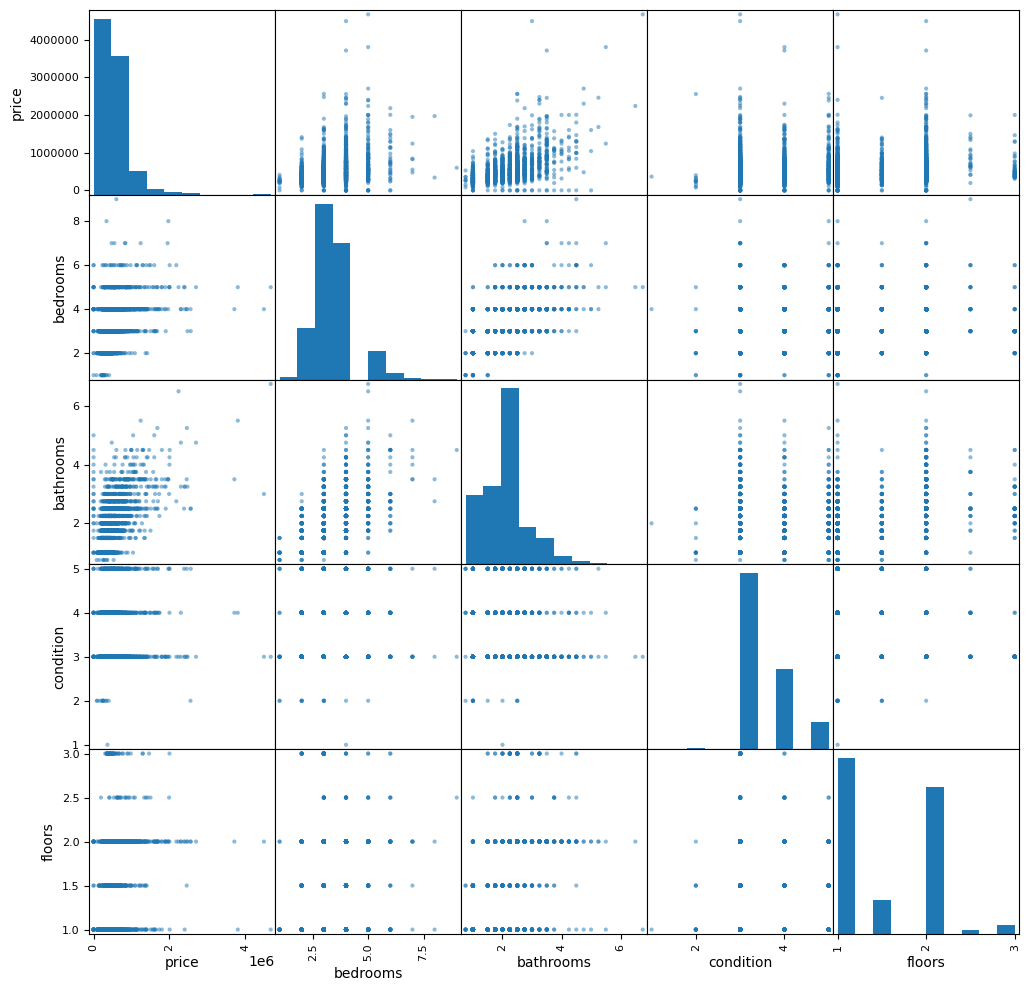

In [6]:
attributes = ["price","bedrooms", "bathrooms", "condition","floors"]
scatter_matrix(train_df[attributes], figsize = (12,12))
plt.show()

The above figures display most of the categorical attributes found in our dataset so it's hard to tell
the correlation between all of them. Now let's plot out more contionus variables and see if we can make some conclusions

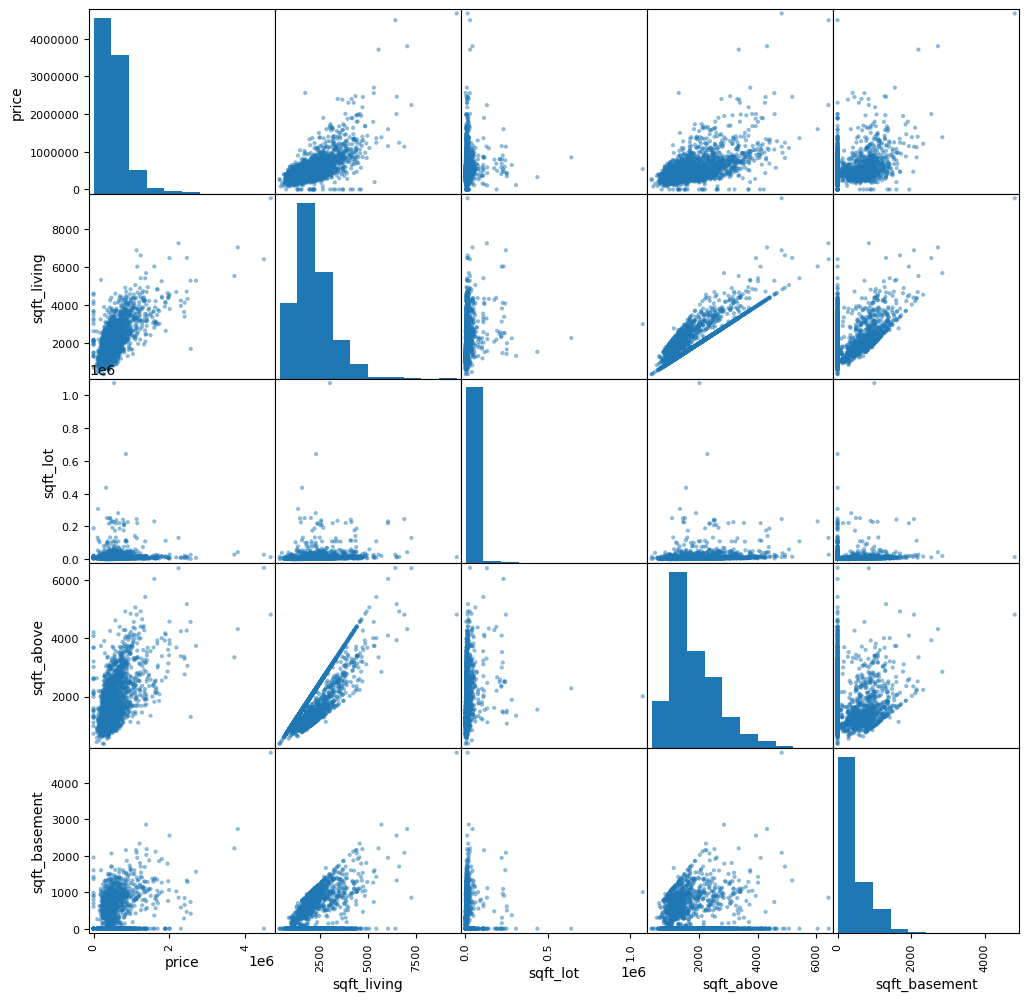

In [7]:
attributes = ["price","sqft_living", "sqft_lot", "sqft_above", 'sqft_basement']
scatter_matrix(train_df[attributes], figsize = (12,12))
plt.show()

There is definitely a lot more visible correlation with the continous attributes which is to be expected. Now I would like to look at plots that look at price vs the other attributes but with price as the y-axis. For the sqft attributes, the histograms are skewed to the right and might be worth eventually transforming by taking the respective logarithms or square roots.

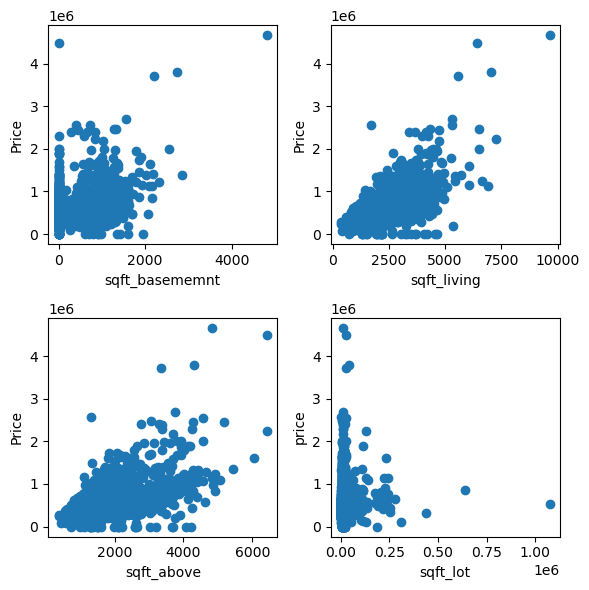

In [8]:
fig, ax = plt.subplots(2,2, figsize = (6,6))

ax[0,0].scatter(train_df['sqft_basement'], train_df['price'])
ax[0,0].set_xlabel('sqft_basememnt')
ax[0,0].set_ylabel('Price')

ax[0,1].scatter(train_df['sqft_living'], train_df['price'])
ax[0,1].set_xlabel('sqft_living')
ax[0,1].set_ylabel('Price')

ax[1,0].scatter(train_df['sqft_above'], train_df['price'])
ax[1,0].set_xlabel('sqft_above')
ax[1,0].set_ylabel('Price')


ax[1,1].scatter(train_df['sqft_lot'], train_df['price'])
ax[1,1].set_xlabel('sqft_lot')
ax[1,1].set_ylabel('price')


plt.tight_layout()
plt.show()

# Handling Categorical Attributes

The only categorical attribute we have is the city column. This is a useful column since cities like Seattle are more expensive to live in as opposed to other cities in Washington. Using a one hot encoder, we are going to transform the column. 



In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore') # Instead of a SciPy sparse matrix, we get a NumPy array
one_hot_encoded_cities = one_hot_encoder.fit_transform(X_train[['city']])
one_hot_encoded_cities_df = pd.DataFrame(one_hot_encoded_cities, columns = one_hot_encoder.get_feature_names_out(), index = X_train.index)
X_train_encoded = pd.concat([X_train, one_hot_encoded_cities_df], axis = 1) 
X_train_encoded.drop('city', axis = 1, inplace = True) # No need for city column anymore
X_train_encoded.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,...,city_Sammamish,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point
4159,4.0,2.5,2610,5140,2.0,0,0,3,2610,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
666,3.0,2.5,3100,20553,1.0,0,0,3,3100,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3337,3.0,1.5,2680,4775,2.0,0,2,5,1880,800,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3794,4.0,1.5,2550,5055,2.0,0,0,4,2550,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4206,3.0,1.0,1450,7200,1.0,0,0,3,1010,440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from src.features import encode_cities_val_test_set
X_val_encoded = encode_cities_val_test_set(X_val, one_hot_encoder)
X_test_encoded = encode_cities_val_test_set(X_test, one_hot_encoder)

# Feature Scaling & Engineering

From the scatter plots for sqft_basement and sqft_lot it is clear there is a vertical line of data points near or at zero. So it's worth checking how many of the points have values of zero

In [11]:
X_train_encoded[X_train['sqft_lot'] == 0]['sqft_lot'].count()

np.int64(0)

In [12]:
X_train_encoded[X_train['sqft_basement'] == 0]['sqft_basement'].count()


np.int64(1214)

For sqft_lot, zero observations have a value of 0. This makes sense since every house should have a lot size. This just means that there are outliers for the lot size that are squishing the data to the left of the graph. To deal with this, we will take the logarithm of the sqft_lot, normalizing the distribution.

For sqft_basement, there are 1214 observations that have a value of 0. Some houses don't have a basement, so this is okay to have. A new column, has_basement, will be made to help provide extra context to the model that helps when training it.

The columns sqft_living and sqft_above are skewed to the right as well, but not as extreme as sqft_lot, so we will just take the square roots of each column 



In [13]:
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp) # For sqft_lot column
cbrt_transformer = FunctionTransformer(np.cbrt, inverse_func = np.exp2) # For sqft_living and sqft_above
X_train_encoded['sqft_lot'] = log_transformer.transform(X_train[['sqft_lot']])
X_train_encoded[['sqft_living', 'sqft_above', 'sqft_basement']] = cbrt_transformer.transform(X_train[['sqft_living', 'sqft_above', 'sqft_basement']])



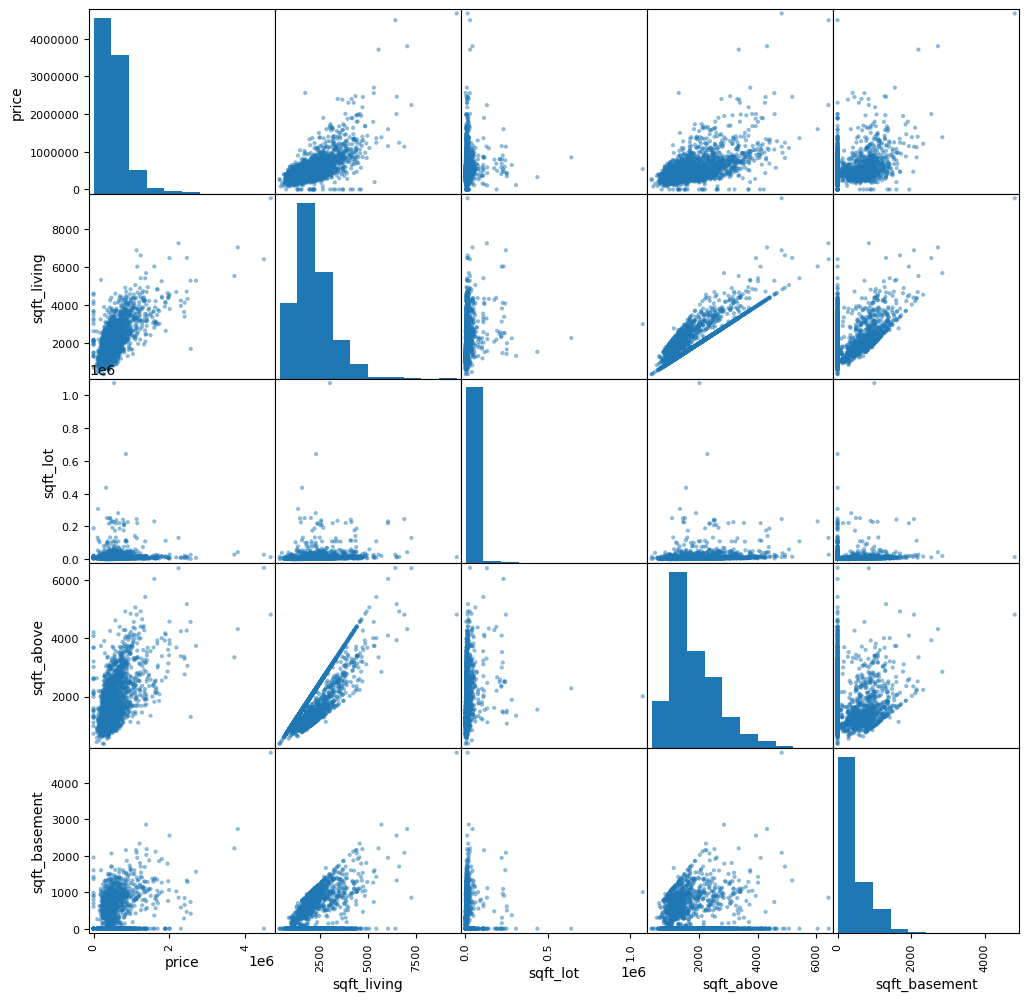

In [14]:
train_df = pd.concat([X_train, y_train], axis = 1)
attributes = ["price","sqft_living", "sqft_lot", "sqft_above", 'sqft_basement']

scatter_matrix(train_df[attributes], figsize = (12,12))
plt.show()

The distributions for the sqft features look a lot better now especially the sqft_lot. Now we can standardize the values to help get the values of each feature around the same scale. Standardization is also less affected by outliers which is great for the dataset since there is a couple outliers for some features.

In [15]:
from src.features import add_basement_features
X_train_encoded = add_basement_features(X_train_encoded)
X_test_encoded = add_basement_features(X_test_encoded)
X_val_encoded = add_basement_features(X_val_encoded)


X_train_encoded.head()



,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,...,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point,has_basement
4159,4.0,2.5,13.768295,8.544808,2.0,0,0,3,13.768295,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
666,3.0,2.5,14.580997,9.930762,1.0,0,0,3,14.580997,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3337,3.0,1.5,13.890299,8.471149,2.0,0,2,5,12.342012,9.283178,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3794,4.0,1.5,13.661972,8.528133,2.0,0,0,4,13.661972,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4206,3.0,1.0,11.318512,8.881836,1.0,0,0,3,10.033223,7.605905,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [16]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X_train_scaled_nparray = standard_scaler.fit_transform(X_train_encoded)
X_train_scaled = pd.DataFrame(X_train_scaled_nparray, index = X_train_encoded.index, columns = X_train_encoded.columns)
X_train_scaled.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,...,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point,has_basement
4159,0.653373,0.425783,0.614992,-0.500079,0.922382,-0.079614,-0.315334,-0.688187,1.028149,-0.812730,...,-0.073198,1.351813,-0.171541,-0.038152,-0.121447,-0.082639,-0.09639,-0.15098,-0.031144,-0.836758
666,-0.435934,0.425783,1.056475,1.024016,-0.954204,-0.079614,-0.315334,-0.688187,1.487456,-0.812730,...,-0.073198,-0.739748,5.829498,-0.038152,-0.121447,-0.082639,-0.09639,-0.15098,-0.031144,-0.836758
3337,-0.435934,-0.837338,0.681268,-0.581080,0.922382,-0.079614,2.252120,2.289629,0.222069,1.232885,...,-0.073198,1.351813,-0.171541,-0.038152,-0.121447,-0.082639,-0.09639,-0.15098,-0.031144,1.195088
3794,0.653373,-0.837338,0.557235,-0.518416,0.922382,-0.079614,-0.315334,0.800721,0.968059,-0.812730,...,-0.073198,1.351813,-0.171541,-0.038152,-0.121447,-0.082639,-0.09639,-0.15098,-0.031144,-0.836758
4206,-0.435934,-1.468899,-0.715798,-0.129459,-0.954204,-0.079614,-0.315334,-0.688187,-1.082769,0.863286,...,-0.073198,-0.739748,-0.171541,-0.038152,-0.121447,-0.082639,-0.09639,-0.15098,-0.031144,1.195088


In [17]:
from src.features import apply_standard_scaler
X_test_scaled = apply_standard_scaler(X_test_encoded, standard_scaler)
X_val_scaled = apply_standard_scaler(X_val_encoded, standard_scaler)


# Transformation Pipeline 
Now that the preprocessing steps are defined we can wrap all of this neatly into a Pipeline, allowing us to train and test various different models more efficiently.

In [18]:
#apply log transformer to sqft_lot
#apply cbrt transformer to sqft_living, sqft_basement, sqft_above

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from src.features import logTransformer
from src.features import cbrtTransformer
preprocess = ColumnTransformer([("onehot_cities", one_hot_encoder, ['city']),("log", logTransformer(), ['sqft_lot']),('cbrt', cbrtTransformer(), ['sqft_living', 'sqft_basement', 'sqft_above'])], remainder = 'passthrough')
pipeline = Pipeline([("preprocess", preprocess),('stdscaler', standard_scaler)])


# we use a custome logTransform instead of functionTransformer so that we can pass the transformed data along as a DataFrame like the pipeline expects


In [19]:
test_df = X_train
pipeline_data = pipeline.fit_transform(test_df) 
pipeline_data


array([[-0.19011728, -0.25819889, -0.04927843, ..., -0.68818703,
         1.20909842, -0.82170389],
       [-0.19011728, -0.25819889, -0.04927843, ..., -0.68818703,
        -0.53627307,  1.22812265],
       [-0.19011728, -0.25819889, -0.04927843, ...,  2.28962855,
        -1.91243136, -0.82170389],
       ...,
       [-0.19011728, -0.25819889, -0.04927843, ..., -0.68818703,
         0.87345006, -0.82170389],
       [-0.19011728, -0.25819889, -0.04927843, ..., -0.68818703,
         0.67206104,  1.23221208],
       [-0.19011728, -0.25819889, -0.04927843, ..., -0.68818703,
        -1.40895881,  1.17598242]])

In [20]:
pipeline_data_df = pd.DataFrame(data=pipeline_data, index = test_df.index, columns= pipeline.get_feature_names_out())

In [21]:
pipeline_data_df

,onehot_cities__city_Auburn,onehot_cities__city_Bellevue,onehot_cities__city_Black Diamond,onehot_cities__city_Bothell,onehot_cities__city_Burien,onehot_cities__city_Carnation,onehot_cities__city_Clyde Hill,onehot_cities__city_Covington,onehot_cities__city_Des Moines,onehot_cities__city_Duvall,...,cbrt__sqft_basement,cbrt__sqft_above,remainder__bedrooms,remainder__bathrooms,remainder__floors,remainder__waterfront,remainder__view,remainder__condition,remainder__yr_built,remainder__yr_renovated
4159,-0.190117,-0.258199,-0.049278,-0.076472,-0.115129,-0.062378,-0.053995,-0.076472,-0.106155,-0.101385,...,-0.812730,1.028149,0.653373,0.425783,0.922382,-0.079614,-0.315334,-0.688187,1.209098,-0.821704
666,-0.190117,-0.258199,-0.049278,-0.076472,-0.115129,-0.062378,-0.053995,-0.076472,-0.106155,-0.101385,...,-0.812730,1.487456,-0.435934,0.425783,-0.954204,-0.079614,-0.315334,-0.688187,-0.536273,1.228123
3337,-0.190117,-0.258199,-0.049278,-0.076472,-0.115129,-0.062378,-0.053995,-0.076472,-0.106155,-0.101385,...,1.232885,0.222069,-0.435934,-0.837338,0.922382,-0.079614,2.252120,2.289629,-1.912431,-0.821704
3794,-0.190117,-0.258199,-0.049278,-0.076472,-0.115129,-0.062378,-0.053995,-0.076472,-0.106155,-0.101385,...,-0.812730,0.968059,0.653373,-0.837338,0.922382,-0.079614,-0.315334,0.800721,-2.013126,-0.821704
4206,-0.190117,-0.258199,-0.049278,-0.076472,-0.115129,-0.062378,-0.053995,-0.076472,-0.106155,-0.101385,...,0.863286,-1.082769,-0.435934,-1.468899,-0.954204,-0.079614,-0.315334,-0.688187,-0.032801,1.233234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,-0.190117,-0.258199,-0.049278,-0.076472,-0.115129,-0.062378,-0.053995,-0.076472,-0.106155,-0.101385,...,-0.812730,0.018295,0.653373,0.110003,-0.954204,-0.079614,-0.315334,0.800721,0.101459,-0.821704
2003,-0.190117,-0.258199,-0.049278,-0.076472,-0.115129,-0.062378,-0.053995,-0.076472,-0.106155,-0.101385,...,-0.812730,0.663504,0.653373,0.425783,0.922382,-0.079614,-0.315334,-0.688187,1.108404,-0.821704
3647,-0.190117,-0.258199,-0.049278,-0.076472,-0.115129,-0.062378,-0.053995,-0.076472,-0.106155,-0.101385,...,0.863286,-1.378652,-0.435934,0.741564,-0.954204,-0.079614,-0.315334,-0.688187,0.873450,-0.821704
4170,-0.190117,-0.258199,-0.049278,-0.076472,-0.115129,-0.062378,-0.053995,-0.076472,-0.106155,-0.101385,...,-0.812730,0.917260,-0.435934,0.425783,0.922382,-0.079614,-0.315334,-0.688187,0.672061,1.232212
